In [1]:
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from pprint import pprint
import os.path as pth

import gzip
import pickle

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Flatten, Reshape
from tensorflow.keras.utils import Sequence

from sklearn.model_selection import train_test_split, KFold, GroupKFold

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
ROOT_DIR = '../data'
TRAIN_IMG_DIR = pth.join(ROOT_DIR, 'original/train_images')
TRAIN_DATA_DIR = ROOT_DIR

WIDTH=1600
HEIGHT=256

In [4]:
data = pd.read_feather(pth.join(TRAIN_DATA_DIR, 'train.feather'))

/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [5]:
data.head()

,imageid,classid,mask_present
0,0002cc93b,1,True
1,0002cc93b,2,False
2,0002cc93b,3,False
3,0002cc93b,4,False
4,00031f466,1,False


In [6]:
with gzip.open(pth.join(TRAIN_DATA_DIR, 'train_masks.pickle.gz'), 'rb') as f:
    image_masks = pickle.load(f)

In [7]:
image_groups = data.groupby('imageid')

image_names = list(data.imageid.unique())[0:1000]
train_cv_image_names, test_image_names = train_test_split(image_names)
len(train_cv_image_names), len(test_image_names)

(750, 250)

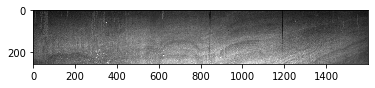

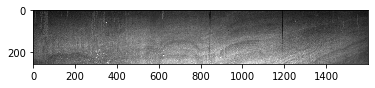

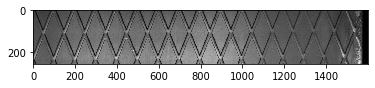

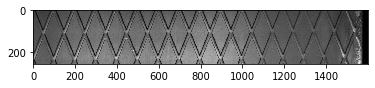

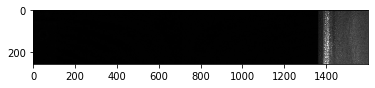

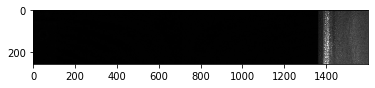

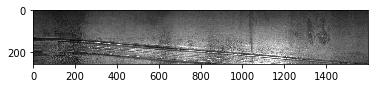

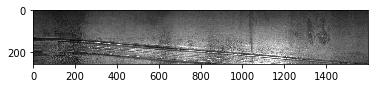

In [61]:
from loaders import BlockwiseImageLoader
n = 4
b = BlockwiseImageLoader(train_cv_image_names[0:10], image_groups, image_masks, n, 64, 32)
img_patches, mask_patches = b[0]
imgs = b.combine_patches(img_patches)

for i in range(n):
    name = train_cv_image_names[i]
    im = plt.imread(pth.join(TRAIN_IMG_DIR, f'{name}.jpg')).astype('float32')[:, :, 0]
    plt.figure()
    plt.imshow(im, cmap='gray')
    plt.show()
    plt.figure()
    plt.imshow(imgs[i], cmap='gray')
    plt.show()


In [15]:
b.n_patches_y

7

In [ ]:
kfold = KFold(5)
for train_indices, cv_indices in kfold.split(train_cv_image_names):
    train_image_names = [train_cv_image_names[i] for i in train_indices]
    cv_image_names = [train_cv_image_names[i] for i in cv_indices]
    model.fit_generator(
        generator=ImageLoader(train_image_names, image_groups, image_masks, 8),
        validation_data=ImageLoader(cv_image_names, image_groups, image_masks, 8),
        epochs=5)

In [ ]:
names = test_image_names[0:10]
results = model.predict_generator(ImageLoader(names, image_groups, image_masks, 8))

In [ ]:
for i, name in enumerate(names):
    im = plt.imread(pth.join(TRAIN_IMG_DIR, f'{name}.jpg')).astype('float32')
    im /= 255
    
    print(name)
    plt.figure(figsize=(16, 3))
    plt.imshow(im, cmap='gray')
    plt.show()
    
    for j in [1, 2, 3, 4]:
        rows = data[(data.imageid == name) & (data.classid == j)]
        row = rows.iloc[0, :]

        if row.mask_present:
            mask_ref = image_masks[f'{name}_{j}']
        else:
            mask_ref = np.zeros((HEIGHT, WIDTH), dtype='uint8')
            
        print(name, j, 'REF')
        plt.figure(figsize=(16, 3))
        plt.imshow(mask_ref, cmap='gray')
        plt.show()
        
        mask_test = results[j - 1][i].squeeze()
        #mask_test = (mask_test > 0.5).astype('uint8')
        
        
        print(name, j, 'TEST', np.sum(mask_ref != mask_test))
        plt.figure(figsize=(16, 3))
        plt.imshow(mask_test, cmap='gray')
        plt.show()
